# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model. This will be demonstrated for Mike's example model in the California current. You are encouraged to follow along with this notebook to generate the model grid in the domain for your project.

First, import packages to re-create and visualize the model grid here:

## GPU-SERVER: Mount Google Drive (Colab)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Dependency


In [ ]:
!pip install -q netcdf4

## Import Libraries and Modules


In [ ]:
import os
import gc
import time
from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

## Configuration


In [ ]:
MYDRIVE_DIR = Path("/content/drive/MyDrive")
os.chdir(MYDRIVE_DIR)

DATA_DIR = Path("/content/drive/MyDrive/data/cs185c")
GEBCO_FILE = DATA_DIR / "GEBCO_2024.nc"
OUTPUT_FILE = "global_bathymetry.bin"
TARGET_DTYPE = jnp.float32

CENTRAL_WET_ROW = 300
CENTRAL_WET_COL = 300

DEL_X = 1 / 2
DEL_Y = 1 / 2
XG_ORIGIN = -180
YG_ORIGIN = -90
N_ROWS = 360
N_COLS = 720

## Helper Functions

In [ ]:
@jax.jit
def generate_connected_mask_jax(
    start_row: int, start_col: int, wet_grid_jax: jax.Array
) -> jax.Array:
    """
    Generates a mask identifying wet cells connected to a starting point using
    JAX.

    Args:
        start_row: The row index of the starting wet cell.
        start_col: The column index of the starting wet cell.
        wet_grid_jax: A 2D JAX array where 1 represents wet cells and 0
                      represents dry cells.

    Returns:
        A 2D JAX array (mask_grid) with states:
          0: Unverified wet cell (potentially unconnected)
          1: Verified dry cell
          2: Verified wet cell connected to the start point
    """
    rows, cols = wet_grid_jax.shape
    mask_grid = jnp.where(wet_grid_jax == 0, 1, 0).astype(jnp.int32)
    mask_grid = mask_grid.at[start_row, start_col].set(2)
    initial_state = (mask_grid, True)

    def condition_fun(state):
        _, did_change = state
        return did_change

    def body_fun(state):
        current_mask, _ = state
        frontier = (current_mask == 2)
        up    = jnp.roll(frontier, shift=1, axis=0)
        down  = jnp.roll(frontier, shift=-1, axis=0)
        left  = jnp.roll(frontier, shift=1, axis=1)
        right = jnp.roll(frontier, shift=-1, axis=1)
        neighbors_connected = up | down | left | right
        newly_verified_indices = (current_mask == 0) & neighbors_connected
        next_mask = jnp.where(newly_verified_indices, 2, current_mask)
        did_change = jnp.any(next_mask != current_mask)
        return (next_mask, did_change)

    final_state = jax.lax.while_loop(condition_fun, body_fun, initial_state)
    final_mask_grid, _ = final_state
    return final_mask_grid

@jax.jit
def fill_unconnected_model_regions_jax(
    bathymetry_grid_jax: jax.Array, central_wet_row: int, central_wet_col: int
) -> jax.Array:
    """
    Fills unconnected wet regions in a bathymetry grid using JAX.

    Sets bathymetry values to 0 for wet cells that are not connected
    to the specified central wet cell.

    Args:
        bathymetry_grid_jax: 2D JAX array of bathymetry values (negative for
                             wet, >=0 for dry).
        central_wet_row: The row index of the central wet cell to start
                         connectivity check from.
        central_wet_col: The column index of the central wet cell.

    Returns:
        A 2D JAX array with unconnected wet regions filled (set to 0).
    """
    wet_grid = jnp.where(bathymetry_grid_jax < 0, 1, 0).astype(jnp.int32)
    mask_grid = generate_connected_mask_jax(
        central_wet_row, central_wet_col, wet_grid
    )
    filled_bathymetry = jnp.where(mask_grid == 0, 0.0, bathymetry_grid_jax)
    return filled_bathymetry

@jax.jit
def nearest_neighbor_interp_jax(
    target_lon, target_lat, source_lon_1d, source_lat_1d, source_values
):
    """ JAX implementation of nearest neighbor interpolation """
    lon_diff = jnp.abs(target_lon[:, :, None] - source_lon_1d[None, None, :])
    nearest_lon_idx = jnp.argmin(lon_diff, axis=2)
    lat_diff = jnp.abs(target_lat[:, :, None] - source_lat_1d[None, None, :])
    nearest_lat_idx = jnp.argmin(lat_diff, axis=2)
    interpolated_values = source_values[nearest_lat_idx, nearest_lon_idx]
    return interpolated_values

## Check Hardware

In [ ]:
print(f"JAX backend: {jax.default_backend()}")

try:
    print(f"JAX devices: {jax.devices()}")
    _ = jnp.zeros(1, dtype=TARGET_DTYPE).block_until_ready()

    print("GPU access confirmed.")
    gpu_device = jax.devices('gpu')[0]
except (RuntimeError, IndexError) as e:
    print(f"Warning: Could not access GPU. Using CPU. Error: {e}")
    try:
        gpu_device = jax.devices('cpu')[0]
    except IndexError:
        print("Error: No JAX devices found (CPU or GPU). Exiting.")
        exit()

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
GPU access confirmed.


## Load Data (NumPy)

In [ ]:
print(f"Loading GEBCO data from: {GEBCO_FILE}")

start_load_time = time.time()
try:
    with Dataset(GEBCO_FILE, 'r') as gebco_ds:
        lon_var = gebco_ds.variables['lon']
        lat_var = gebco_ds.variables['lat']
        bathy_var = gebco_ds.variables['elevation']
        gebco_lon_ma = lon_var[:]
        gebco_lat_ma = lat_var[:]
        gebco_bathy_ma = bathy_var[:]
        gebco_lon_np = np.ma.filled(gebco_lon_ma).astype(np.float32)
        gebco_lat_np = np.ma.filled(gebco_lat_ma).astype(np.float32)
        gebco_bathy_np = np.ma.filled(gebco_bathy_ma).astype(np.float32)
except FileNotFoundError:
    print(f"Error: GEBCO file not found at {GEBCO_FILE}.")
    exit()
except Exception as e:
    print(f"An error occurred during NetCDF loading: {e}")
    exit()

load_time = time.time() - start_load_time
print(f"Data loaded and filled in {load_time:.2f} seconds.")
print(
    f"GEBCO Bathy memory size (NumPy float32): "
      + "{gebco_bathy_np.nbytes / (1024**3):.2f} GB"
)
print(
    "Skipping Plot 1 (Original GEBCO Data) due to excessive memory"
      + "requirements."
)

Loading GEBCO data from: /content/drive/MyDrive/data/cs185c/GEBCO_2024.nc
Data loaded and filled in 13.14 seconds.
GEBCO Bathy memory size (NumPy float32): {gebco_bathy_np.nbytes / (1024**3):.2f} GB
Skipping Plot 1 (Original GEBCO Data) due to excessive memoryrequirements.


## Transfer to JAX


In [ ]:
print("Transferring data to JAX arrays...")
start_transfer_time = time.time()

gebco_lon = jax.device_put(
    jnp.asarray(gebco_lon_np, dtype=TARGET_DTYPE), gpu_device
)
gebco_lat = jax.device_put(
    jnp.asarray(gebco_lat_np, dtype=TARGET_DTYPE), gpu_device
)
gebco_bathy = jax.device_put(
    jnp.asarray(gebco_bathy_np, dtype=TARGET_DTYPE), gpu_device
)

del gebco_lon_np
del gebco_lat_np
del gebco_bathy_np
try:
  del gebco_lon_ma
  del gebco_lat_ma
  del gebco_bathy_ma
except NameError:
  pass
gc.collect()

# Wait for transfer
gebco_lon.block_until_ready()
gebco_lat.block_until_ready()
gebco_bathy.block_until_ready()

transfer_time = time.time() - start_transfer_time
print(
    f"Data transferred to JAX device ({gpu_device.platform}) "
      + "in {transfer_time:.2f} seconds."
)

Transferring data to JAX arrays...
Data transferred to JAX device (gpu) in {transfer_time:.2f} seconds.


## Create Target Grid

In [ ]:
print("Creating target grid...")

xc_np = np.arange(
    XG_ORIGIN + DEL_X / 2, XG_ORIGIN + N_COLS * DEL_X, DEL_X
).astype(np.float32)
yc_np = np.arange(
    YG_ORIGIN + DEL_Y / 2, YG_ORIGIN + N_ROWS * DEL_Y, DEL_Y
).astype(np.float32)
XC_np, YC_np = np.meshgrid(xc_np, yc_np, indexing='xy')
xc = jax.device_put(jnp.asarray(xc_np, dtype=TARGET_DTYPE), gpu_device)
yc = jax.device_put(jnp.asarray(yc_np, dtype=TARGET_DTYPE), gpu_device)
XC, YC = jnp.meshgrid(xc, yc, indexing='xy')
print(f'Target grid shape (XC, YC): {XC.shape}')

Creating target grid...
Target grid shape (XC, YC): (360, 720)


## Interpolate (Jax)

In [ ]:
print("Performing nearest neighbor interpolation using JAX...")
start_interp_time = time.time()

bathy_model_jax = nearest_neighbor_interp_jax(
    XC, YC, gebco_lon, gebco_lat, gebco_bathy
)
bathy_model_jax.block_until_ready()
interp_time = time.time() - start_interp_time
print(f"JAX interpolation finished in {interp_time:.2f} seconds.")

del gebco_lon
del gebco_lat
del gebco_bathy
gc.collect()

Performing nearest neighbor interpolation using JAX...
JAX interpolation finished in 0.29 seconds.


0

## Normalize/Mask Land


In [ ]:
print("Masking land points...")
start_mask_time = time.time()

bathy_model_masked = jnp.where(bathy_model_jax > 0, 0.0, bathy_model_jax)
bathy_model_masked.block_until_ready()
mask_time = time.time() - start_mask_time
print(f"Land masking finished in {mask_time:.2f} seconds.")

del bathy_model_jax
gc.collect()

Masking land points...
Land masking finished in 0.00 seconds.


0

## Plot 2: Interpolated/Masked Model Bathymetry

Transferring masked bathymetry back to NumPy for plotting...
Transfer for plotting took 0.00 seconds.
Generating Plot 2: Interpolated/Masked Model Bathymetry...


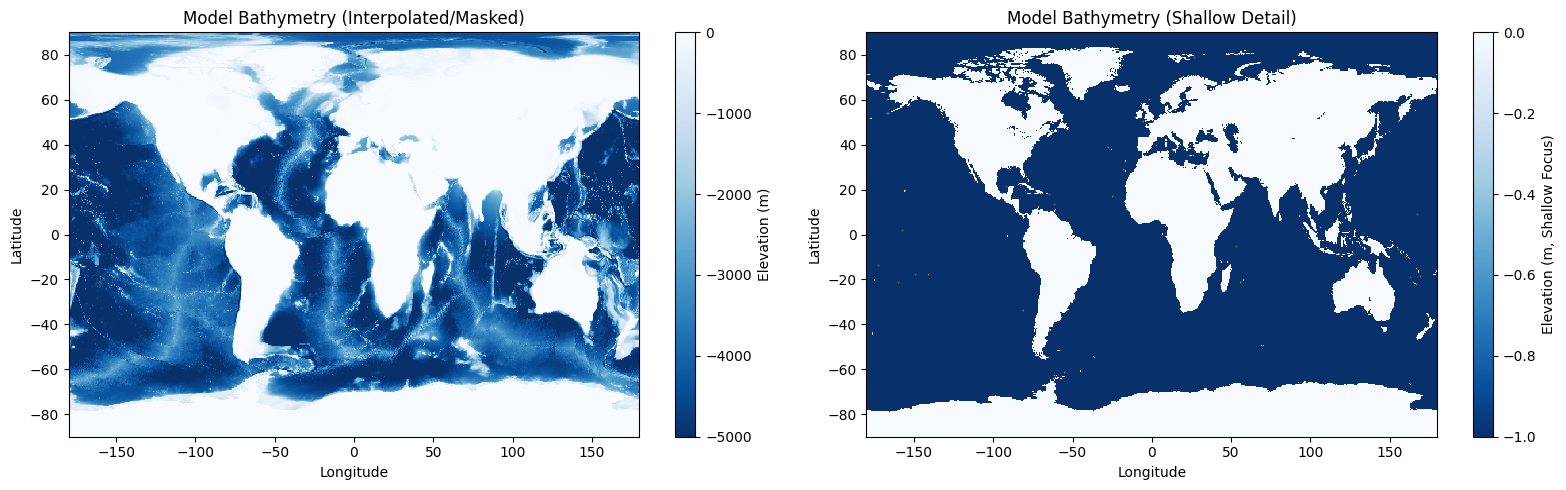

11010

In [ ]:
print("Transferring masked bathymetry back to NumPy for plotting...")
start_plot_transfer_time = time.time()
bathy_model_masked_np = np.array(bathy_model_masked) # Transfer for plotting
plot_transfer_time = time.time() - start_plot_transfer_time
print(f"Transfer for plotting took {plot_transfer_time:.2f} seconds.")

print("Generating Plot 2: Interpolated/Masked Model Bathymetry...")
try:
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    C1 = plt.pcolormesh(
        XC_np,
        YC_np,
        bathy_model_masked_np,
        vmin=-5000,
        vmax=0,
        cmap='Blues_r',
        shading='auto'
    )
    plt.colorbar(C1, label='Elevation (m)')
    plt.title('Model Bathymetry (Interpolated/Masked)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 2, 2)
    C2 = plt.pcolormesh(
        XC_np,
        YC_np,
        bathy_model_masked_np,
        vmin=-1,
        vmax=0,
        cmap='Blues_r',
        shading='auto'
    )
    plt.colorbar(C2, label='Elevation (m, Shallow Focus)')
    plt.title('Model Bathymetry (Shallow Detail)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()
except Exception as e:
  print(
      f"Warning: An error occurred during Plot 2 generation: {e}. "
        + "Skipping Plot 2."
  )

del bathy_model_masked_np
gc.collect()

## Fill Unconnected Regions

In [ ]:
print("Filling unconnected regions using JAX...")
start_fill_time = time.time()

# Call the JIT-compiled JAX function directly on the JAX array
# The result is now the final bathymetry grid for saving/plotting
bathy_model_final_jax = fill_unconnected_model_regions_jax(
    bathy_model_masked, CENTRAL_WET_ROW, CENTRAL_WET_COL
)
bathy_model_final_jax.block_until_ready() # Wait for computation
fill_time = time.time() - start_fill_time
print(f"JAX fill unconnected regions finished in {fill_time:.2f} seconds.")

del bathy_model_masked
gc.collect()

Filling unconnected regions using JAX...
JAX fill unconnected regions finished in 0.31 seconds.


0

## Final Filled Model Bathymetry


Transferring final bathymetry back to NumPy for plotting...
Transfer for plotting took 0.00 seconds.
Generating Plot 3: Final Model Bathymetry (Connected Regions Only)...


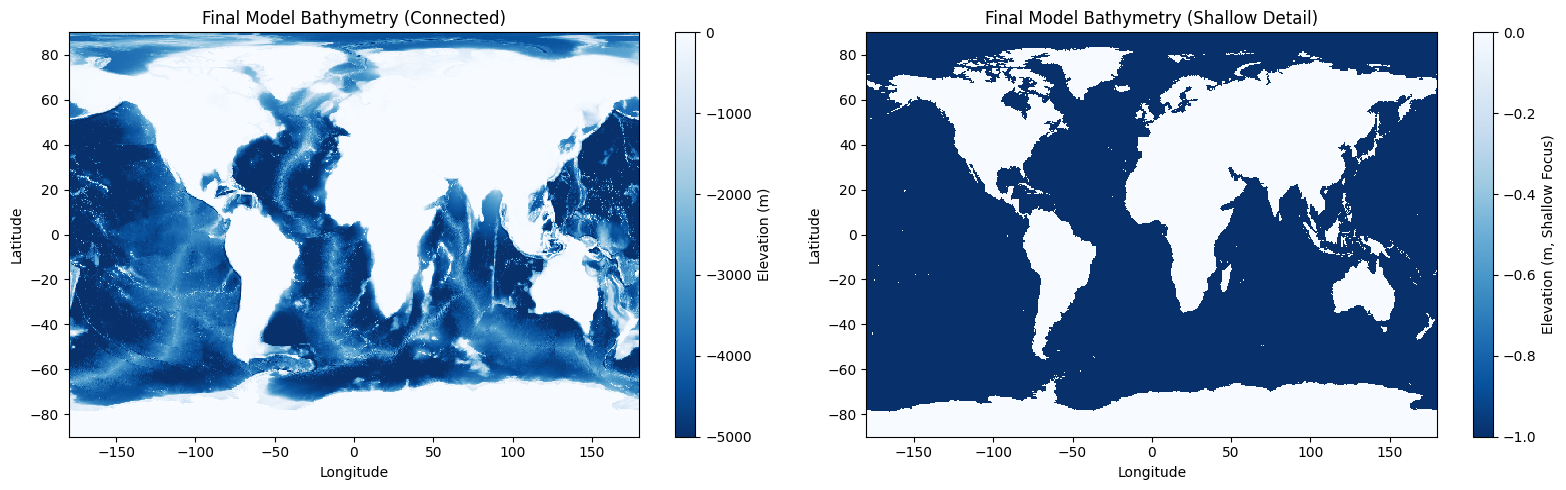

In [ ]:
print("Transferring final bathymetry back to NumPy for plotting...")
start_plot_transfer_time = time.time()

# Transfer for plotting
bathy_model_final_np = np.array(bathy_model_final_jax)
plot_transfer_time = time.time() - start_plot_transfer_time
print(f"Transfer for plotting took {plot_transfer_time:.2f} seconds.")

print("Generating Plot 3: Final Model Bathymetry (Connected Regions Only)...")
try:
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    C1 = plt.pcolormesh(
        XC_np,
        YC_np,
        bathy_model_final_np,
        vmin=-5000,
        vmax=0,
        cmap='Blues_r',
        shading='auto'
    )

    plt.colorbar(C1, label='Elevation (m)')
    plt.title('Final Model Bathymetry (Connected)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.subplot(1, 2, 2)
    C2 = plt.pcolormesh(
        XC_np,
        YC_np,
        bathy_model_final_np,
        vmin=-1,
        vmax=0,
        cmap='Blues_r',
        shading='auto'
    )
    plt.colorbar(C2, label='Elevation (m, Shallow Focus)')
    plt.title('Final Model Bathymetry (Shallow Detail)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()
except Exception as e:
  print(
      f"Warning: An error occurred during Plot 3 generation: {e}. "
        + "Skipping Plot 3."
  )

## Save to File (NumPy)

In [ ]:
print(f"Saving final bathymetry to {OUTPUT_FILE}...")
start_save_time = time.time()

bathy_model_final_np.ravel().astype('>f4').tofile(OUTPUT_FILE)
save_time = time.time() - start_save_time
print(f"Data saved in {save_time:.2f} seconds.")

del bathy_model_final_jax
del bathy_model_final_np
del xc_np
del yc_np
del XC_np
del YC_np
gc.collect()

print("\n--- Summary ---")
print(f"Total Load Time: {load_time:.2f}s")
print(f"NumPy -> JAX Transfer Time: {transfer_time:.2f}s")
print(f"JAX Interpolation Time: {interp_time:.2f}s")
print(f"JAX Masking Time: {mask_time:.2f}s")
print(f"JAX Fill Unconnected Time: {fill_time:.2f}s")
print(f"Save Time: {save_time:.2f}s")

total_time = time.time() - start_load_time
print(f"Approximate Total Script Time: {total_time:.2f}s")

Saving final bathymetry to global_bathymetry.bin...
Data saved in 0.01 seconds.

--- Summary ---
Total Load Time: 13.14s
NumPy -> JAX Transfer Time: 3.17s
JAX Interpolation Time: 0.29s
JAX Masking Time: 0.00s
JAX Fill Unconnected Time: 0.31s
Save Time: 0.01s
Approximate Total Script Time: 18.86s


This will be implemented into the model by renaming each bathy file and editing the `PARM05` dataset of the `data` file as follows:

```
 &PARM05
 bathyFile = 'global_bathymetry.bin,
 &
```